In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
import random
from scipy.optimize import curve_fit

import h5py
from IPython.utils import io

In [28]:
%matplotlib inline

In [6]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../../../nadavp/new_trap/Tools/')
sys.path.append('../../../../nadavp/new_trap/Tools/StatFramework/')
import BeadDataFile
from discharge_tools import *

In [3]:
from likelihood_calculator import likelihood_analyser
from likelihood_calculator import GravityFramework
from likelihood_calculator import auxiliary_functions as aux

sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
from signal_model_utilities import *

No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data


[(0.0, 200.0)]

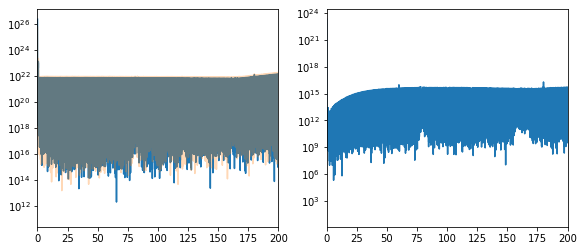

In [5]:
fname = r'/data/new_trap/20200809/Bead1/TransFunc/TransFunc_7_X_z-4e5_250s_1Hz.h5'
tf_x = BeadDataFile.BeadDataFile(fname)
fname = r'/data/new_trap/20200809/Bead1/TransFunc/TransFunc_7_Y_z-4e5_250s_1Hz.h5'
tf_y = BeadDataFile.BeadDataFile(fname)
fname = r'/data/new_trap/20200809/Bead1/TransFunc/TransFunc_7_Z_z-4e5_250s_1Hz.h5'
tf_z = BeadDataFile.BeadDataFile(fname)

_,ax = plt.subplots(1,2,figsize=(9.5,4))
ax[0].semilogy(*tf_x.psd('x'))
ax[0].semilogy(*tf_y.psd('y'), alpha=0.3)
ax[1].semilogy(*tf_z.psd('z'))
ax[0].set(xlim=(0,200))
ax[1].set(xlim=(0,200))

In [6]:
bdf_discharge = load_dir('/home/data_transfer/data_from_windows/20200809/Bead1/Discharge/')

113  files in folder
113  files loaded


In [7]:
bdf_discharge_new = bdf_discharge[45:]

In [8]:
resp_y = [np.std(bb.response_at_freq('y', drive_freq=71)) for bb in bdf_discharge_new]
electrode1 = [np.std(bb.electrode_data[0])*np.sqrt(2) for bb in bdf_discharge_new]
electrode2 = [np.std(bb.electrode_data[1])*np.sqrt(2) for bb in bdf_discharge_new]
height = [bb.bead_height for bb in bdf_discharge_new]

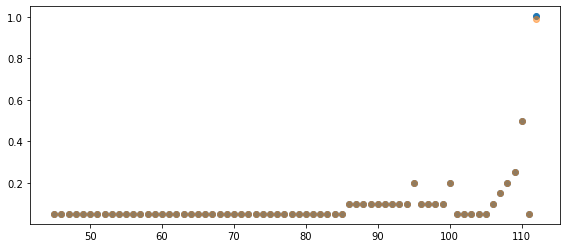

In [49]:
_,ax = plt.subplots(figsize=(9.5,4))
ax.scatter(range(45,113), electrode1)
ax.scatter(range(45,113), electrode2, alpha=0.5)
# ax.scatter(range(len(electrode1)), height)

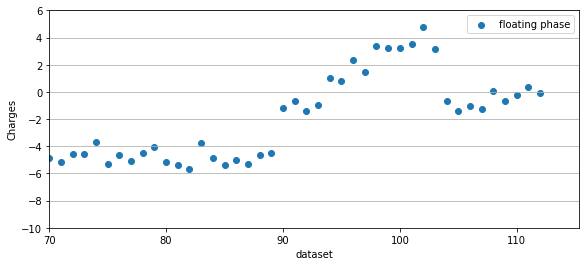

In [113]:
_,ax = plt.subplots(figsize=(9.5,4))
scale = 1

ax.scatter(range(45,113), mm_mle_scale/electrode1/scale, label='floating phase')

ax.legend()
ax.set(xlabel='dataset', ylabel='Charges', ylim=(-10, 6), xlim=(70, None))
ax.grid(axis='y')
ax.legend()
from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

[(-2.0, 2.0)]

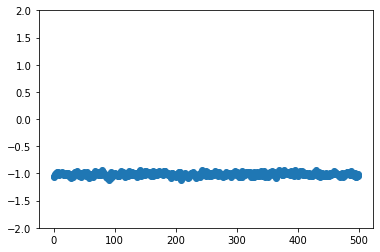

In [101]:
_,ax = plt.subplots()
ax.scatter(range(500), mm_mle_scale2)
ax.set(ylim=(-2,2))

In [92]:
np.mean(mm_mle_scale2)

-0.0314438081377733

In [4]:
from multiprocessing import Pool
bandwidth=1
decimate = 10
ll = likelihood_analyser.LikelihoodAnalyser()

In [7]:
def func1_scale(i):
# for i,bdf_ in enumerate(data_bdfs2):
    print(i,'  ******************')
    fname = r'/data/new_trap/20200809/Bead1/Discharge/Discharge_'+str(i)+'.h5'
#     fname = r'/data/new_trap/20200809/Bead1/Discharge/Response/Discharge_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)
    drive_freq = int(bb.cant_freq)
    fit_kwargs = {'A': 0, 'f': drive_freq, 'phi': -0.03,
                  'error_A': 1, 'error_f': 1, 'error_phi': 0.5, 'errordef': 1,
                  'limit_phi': [-2 * np.pi, 2 * np.pi], 'limit_A': [-1000, 1000], 
                  'print_level': 0, 'fix_f': True, 'fix_phi': True}
    
    f = h5py.File(fname,'r')
    pos_data = np.array(f['pos_data'])
    sync = pos_data.reshape(-1,11).T[5]
    trig_on = np.nonzero(sync)[0][0]

    frequency = fit_kwargs['f']

    xx2 = bb.response_at_freq('y', frequency, bandwidth=bandwidth) / 100000
    xx2 = xx2[5000+trig_on:-5000+trig_on:decimate]  # cut out the first and last second

    m1_tmp = ll.find_mle_sin(xx2, fsamp=5000 / decimate,
                                     noise_rms=1,
                                     plot=False, suppress_print=True, **fit_kwargs)


    return m1_tmp.values[2]

if __name__ == '__main__':
    pool = Pool(processes=40)                         # Create a multiprocessing Pool
    mm_mle_scale = np.array(pool.map(func1_scale, range(70,85)))
    pool.close()

70717372757476       83  ******************  ******************  ******************  ******************  ******************84  ******************  ******************


 

 

  ******************  ******************

7778818082       ******************  ******************  ******************  ******************


79  ******************

   ******************


In [8]:
scaleX = np.mean(mm_mle_scale)/5
scaleX

-0.006000000000000003

In [119]:
def func1(i):
# for i,bdf_ in enumerate(data_bdfs2):
    print(i,'  ******************')
    fname = r'/data/new_trap/20200809/Bead1/Neutrality/71Hz50VNoSpin/Discharge_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)
    drive_freq = int(bb.cant_freq)
    fit_kwargs = {'A': 0, 'f': drive_freq, 'phi': -0.03,
                  'error_A': 1, 'error_f': 1, 'error_phi': 0.5, 'errordef': 1,
                  'limit_phi': [-2 * np.pi, 2 * np.pi], 'limit_A': [-1000, 1000], 
                  'print_level': 0, 'fix_f': True, 'fix_phi': True}
    
    f = h5py.File(fname,'r')
    pos_data = np.array(f['pos_data'])
    sync = pos_data.reshape(-1,11).T[5]
    trig_on = np.nonzero(sync)[0][0]

    frequency = fit_kwargs['f']

    xx2 = bb.response_at_freq('y', frequency, bandwidth=bandwidth) / 100000
    xx2 = xx2[5000+trig_on:-5000+trig_on:decimate]  # cut out the first and last second

    m1_tmp = ll.find_mle_sin(xx2, fsamp=5000 / decimate,
                                     noise_rms=1,
                                     plot=False, suppress_print=True, **fit_kwargs)


    return m1_tmp.values[0]

if __name__ == '__main__':
    pool = Pool(processes=40)                         # Create a multiprocessing Pool
    mm_71Hz50VNoSpin = np.array(pool.map(func1, range(3000)))
    pool.close()

247   ******************
133   ******************
228   ******************
76   ******************
114   ******************
152   ******************
38   ******************
95   ******************
0   ******************
342   ******************
570   ******************
399   ******************
551   ******************
513   ******************
57   ******************
532   ******************
475   ******************
361   ******************
266   ******************
437   ******************
323   ******************
304   ******************
285   ******************
380   ******************
19   ******************
589   ******************
494   ******************
646   ******************
665   ******************
703   ******************
684   ******************
608   ******************
190   ******************
456   ******************
209   ******************
171   ******************
722   ******************
418   ******************
741   ******************
627   ******************
96   **

### 71Hz, different spin

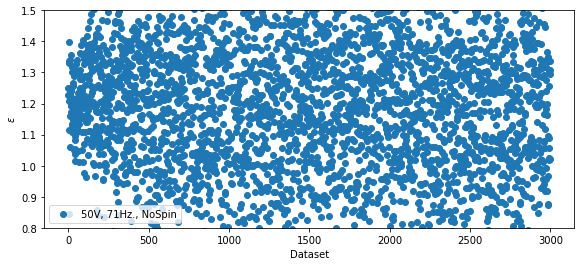

In [125]:
_, ax= plt.subplots(figsize=(9.5,4))
ax.scatter(range(len(mm_71Hz50VNoSpin)), mm_71Hz50VNoSpin/5/scaleX, label='50V, 71Hz., NoSpin')
ax.set(xlabel='Dataset', ylabel=r'$\epsilon$', ylim=(0.8, 1.5))
ax.legend()

<IPython.core.display.Javascript object>


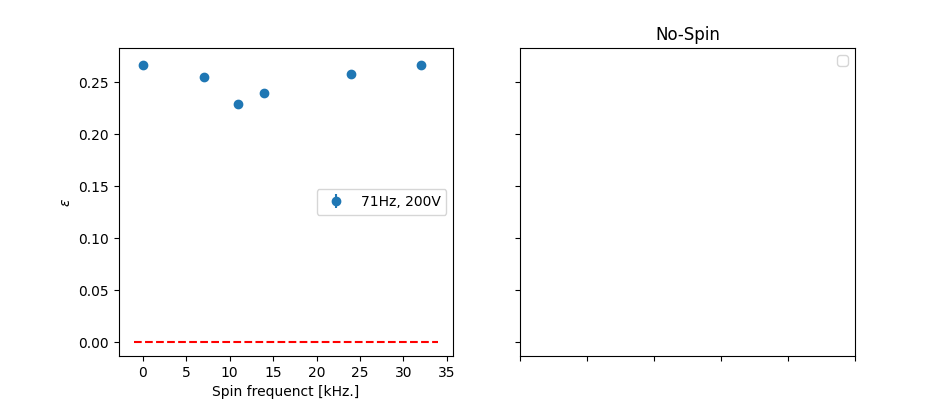

No handles with labels found to put in legend.


[Text(0.5, 1.0, 'No-Spin')]

In [163]:
means = [np.mean(mm_71Hz50VNoSpin/5/scaleX), np.mean(mm_71Hz200V7kHzSpin/20/scaleX), np.mean(mm_71Hz200V11kHzSpin/20/scaleX), 
        np.mean(mm_71Hz200V14kHzSpin/20/scaleX), np.mean(mm_71Hz200V24kHzSpin/20/scaleX), np.mean(mm_71Hz200V32kHzSpin/20/scaleX)]
stds = [np.std(mm_71Hz50VNoSpin/5/scaleX)/np.sqrt(500), np.std(mm_71Hz200V7kHzSpin/20/scaleX)/np.sqrt(500), np.std(mm_71Hz200V11kHzSpin/20/scaleX)/np.sqrt(500)
       ,np.std(mm_71Hz200V14kHzSpin/20/scaleX)/np.sqrt(500),np.std(mm_71Hz200V24kHzSpin/20/scaleX)/np.sqrt(500), np.std(mm_71Hz200V32kHzSpin/20/scaleX)/np.sqrt(500)]
spin_freqs = [0, 7, 11, 14, 24, 32]


_,ax = plt.subplots(1,2,figsize=(9.5,4), sharey=True)
ax[0].errorbar(spin_freqs, means, yerr=stds, fmt='o', label='71Hz, 200V')
ax[0].plot(np.arange(-1,35),np.arange(-1,35)*0, 'r--')
ax[0].set(xlabel='Spin frequenct [kHz.]', ylabel=r'$\epsilon$')
[a.legend() for a in ax]
ax[1].xaxis.set_ticklabels([])
ax[1].set(title='No-Spin')

### Look at the spin

In [159]:
def funcS(i):
    print(i,'  ******************')
    fname = r'/data/new_trap/20200809/Bead1/Neutrality/71Hz200V71.kHzSpin/Discharge_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)
    b, a = matplotlib.mlab.psd(bb.spin_data, Fs = 200000, NFFT = 20000)
    cutoff = int(3000/10)
    return (a[np.argmax(b[cutoff:])+cutoff])
    

if __name__ == '__main__':
    pool = Pool(processes=40)                         # Create a multiprocessing Pool
    observed_spin3 = np.array(pool.map(funcS, range(500)))
    pool.close()

8   ******************
0   ******************
16   ******************
20   ******************
72   ******************
64   ******************
92   ******************
36   ******************
44   ******************
24   ******************
144   ******************
88   ******************
84   ******************
124   ******************
80   ******************
152   ******************
100   ******************
96   ******************
76   ******************
132   ******************
32   ******************
128   ******************
148   ******************
68   ******************
116   ******************
48   ******************
52   ******************
12   ******************
60   ******************
56   ******************
140   ******************
108   ******************
104   ******************
4   ******************
120   ******************
156   ******************
136   ******************
112   ******************
40   ******************
28   ******************
85   ******************
86  

<IPython.core.display.Javascript object>


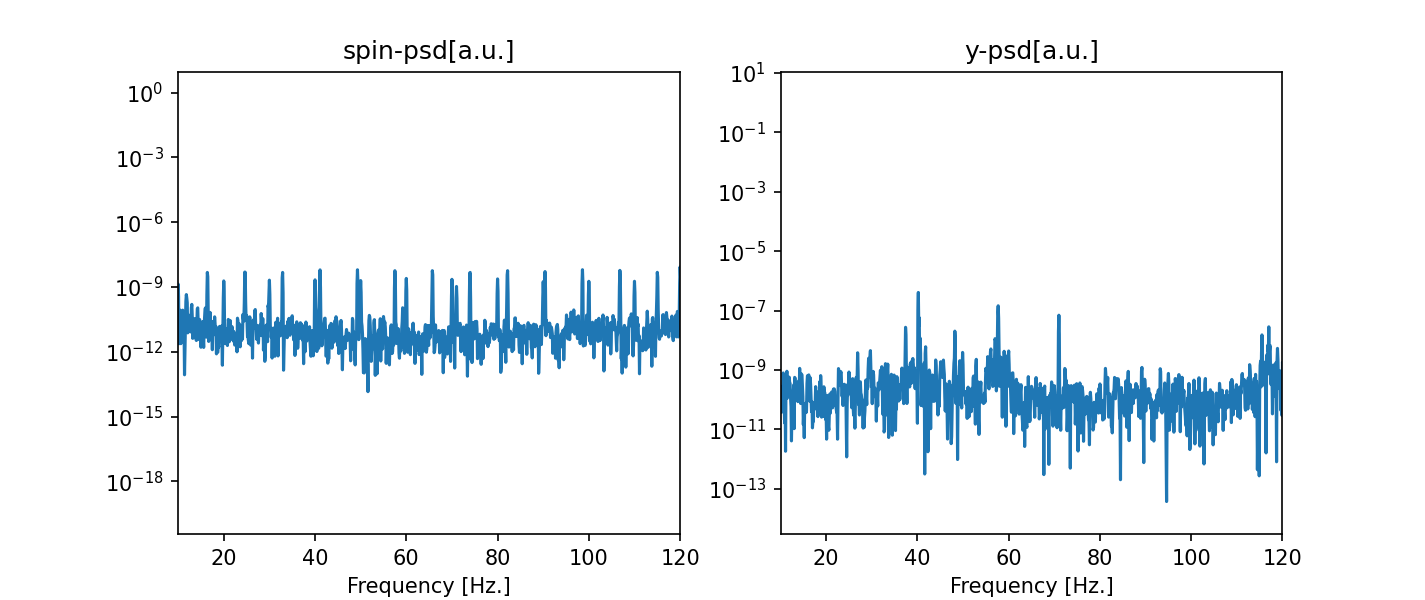

[(10.0, 120.0), Text(0.5, 0, 'Frequency [Hz.]'), Text(0.5, 1.0, 'y-psd[a.u.]')]

In [228]:
datafile_num = 100
fname = r'/data/new_trap/20200809/Bead1/Neutrality/71Hz50VNoSpin/Discharge_'+str(datafile_num)+'.h5'
# fname = r'/data/new_trap/20200809/Bead1/Discharge/Discharge_'+str(datafile_num)+'.h5'
# fname = r'/data/new_trap/20200809/Bead1/Discharge/Discharge_50.h5'

bb = BeadDataFile.BeadDataFile(fname=fname)
_,ax = plt.subplots(1,2,figsize=(9.5,4))
aa1, bb1 = matplotlib.mlab.psd(bb.spin_data, Fs = 200000, NFFT = 2000000)
ax[0].semilogy(bb1, aa1, label='spin')
aa1, bb1 = matplotlib.mlab.psd(bb.y2, Fs = 5000, NFFT = 50000)
ax[1].semilogy(bb1, aa1, label='y')
# ax.legend()
ax[0].set(xlim=(10,120), xlabel='Frequency [Hz.]', title='spin-psd[a.u.]')
ax[1].set(xlim=(10,120), xlabel='Frequency [Hz.]', title='y-psd[a.u.]')

<IPython.core.display.Javascript object>


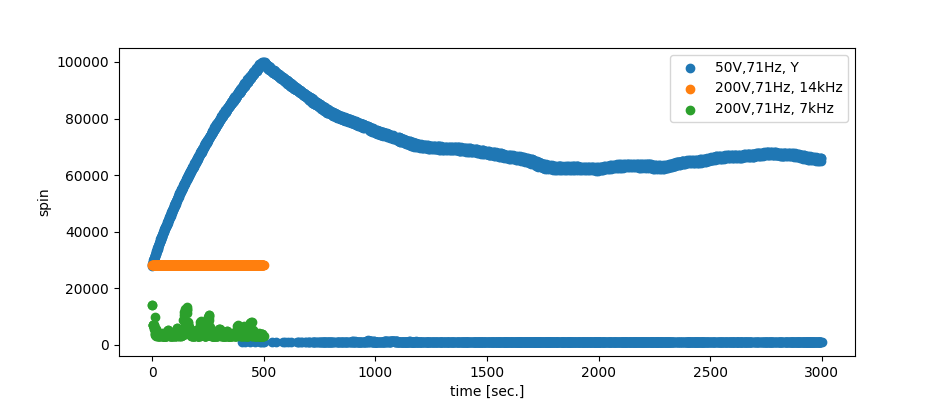

In [160]:
_,ax = plt.subplots(figsize=(9.5,4))
ax.scatter(np.arange(len(observed_spin1)), observed_spin1, label='50V,71Hz, Y')
ax.scatter(np.arange(len(observed_spin2)), observed_spin2, label='200V,71Hz, 14kHz')
ax.scatter(np.arange(len(observed_spin3)), observed_spin3, label='200V,71Hz, 7kHz')
ax.set(xlabel='time [sec.]', ylabel='spin')
ax.legend()

<IPython.core.display.Javascript object>


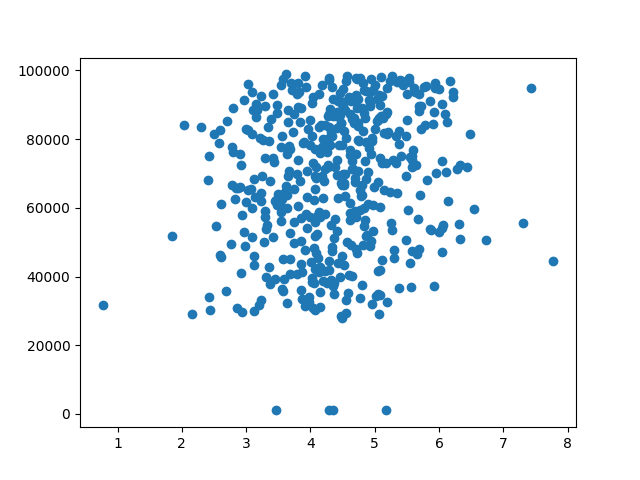

(476, 1.019723062294549, 0.006026997563512228)

In [55]:
_,ax = plt.subplots()
ax.scatter(mm_71Hz50VNoSpin, observed_spin1)
ttt = np.array([mm for mm,mm2 in zip(mm_71Hz200V7kHzSpin, observed_spin1) if mm2>5000])
len(ttt), np.mean(ttt/5/scaleX), np.std(ttt/5/scaleX)/np.sqrt(len(ttt))

In [68]:
def func2(i, lasti):
# for i,bdf_ in enumerate(data_bdfs2):
    print(i,'  ******************')
    fname = r'/data/new_trap/20200730/Bead2/Neutrality/71Hz200V32kHzSpin/Discharge_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)
    drive_freq = int(bb.cant_freq)
#     freqs.append(drive_freq)
    fit_kwargs = {'A': 0, 'f': drive_freq, 'phi': -0.056, 'A2': 0.13, 'f2': drive_freq,
                  'delta_phi': 0.07,
                  'error_A': 1, 'error_f': 1, 'error_phi': 0.5, 'errordef': 1,
                  'error_A2': 1, 'error_f2': 1, 'error_delta_phi': 0.1,
                  'limit_phi': [-2 * np.pi, 2 * np.pi], 'limit_delta_phi': [-2 * np.pi, 2 * np.pi],
                  'limit_A': [-1000, 1000], 'limit_A2': [0, 1000],
                  'print_level': 0, 'fix_f': True, 'fix_phi': True, 'fix_f2': True, 'fix_delta_phi': True,
                  'fix_A2': True}

    frequency = fit_kwargs['f']
    
    xx2 = bb.response_at_freq2('x', frequency, bandwidth=bandwidth) * 50000
    xx2 = xx2[20000:1*lasti:decimate]  # cut out the first and last second

    xx3 = bb.response_at_freq3('x', frequency, bandwidth=bandwidth) / 6
    xx3 = xx3[20000:1*lasti:decimate]  # cut out the first and last second

    m1_tmp = ll.find_mle_2sin(xx2, xx3, fsamp=5000 / decimate,
                                     noise_rms=1,
                                     noise_rms2=1,
                                     plot=False, suppress_print=True, **fit_kwargs)


    return m1_tmp.values[0]

if __name__ == '__main__':
    pool = Pool(processes=40)                         # Create a multiprocessing Pool
    mm_gg3 = np.array(pool.starmap(func2, ss3))
    pool.close()

89   ******************
0   ******************
26   ******************
78   ******************
15   ******************
63   ******************
30   ******************
52   ******************
93   ******************
67   ******************
56   ******************
41   ******************
19   ******************
4   ******************
82   ******************
8   ******************
97   ******************
71   ******************
34   ******************
45   ******************
23   ******************
86   ******************
38   ******************
75   ******************
12   ******************
49   ******************
60   ******************
90   ******************
1   ******************
16   ******************
64   ******************
27   ******************
53   ******************
94   ******************
31   ******************
5   ******************
57   ******************
79   ******************
68   ******************
42   ******************
91   ******************
35   ****************

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



76   ******************
45   ******************
67   ******************
48   ******************
57   ******************
41   ******************
83   ******************
31   ******************
98   ******************
76   ******************
96   ******************
28   ******************
92   ******************
11   ******************
13   ******************
82   ******************
26   ******************
65   ******************
35   ******************
77   ******************
90   ******************
32   ******************
84   ******************
97   ******************
58   ******************
77   ******************
7   ******************
47   ******************
97   ******************
45   ******************
29   ******************
68   ******************
99   ******************
46   ******************
93   ******************
78   ******************
88   ******************
49   ******************
41   ******************
33   ******************
91   ******************
98   ************

In [67]:
ss3 = [(j,i) for i in range(20050, 20150) for j in range(100)]

In [53]:
len(ss2)/100

100.0

In [44]:
np.mean(mm_gg1), np.std(mm_gg1)/np.sqrt(100), len(mm_gg5000)

(0.4917234521260832, 0.016456796318061066, 7100)

In [45]:
charge_mean = [np.mean(mm_gg5000[j*100:(j+1)*100])/20/scaleX for j in range(71)]
charge_std = [np.std(mm_gg5000[j*100:(j+1)*100])/20/scaleX for j in range(71)]

In [146]:
fname = r'/home/data_transfer/data_from_windows/Testdata/20200805/Discharge_4.h5'
fname = r'/home/data_transfer/data_from_windows/Testdata/20200812/Discharge_16.h5'
bb = BeadDataFile.BeadDataFile(fname)

<IPython.core.display.Javascript object>


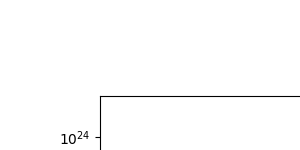

In [155]:
import sys
sys.modules.pop('matplotlib')
from matplotlib import pyplot as plt
_,ax = plt.subplots(1,2)
ax[0].loglog(*bb.psd('x'))
ax[1].loglog(*bb.psd2('x'))
# [a.set(xlim=(0,400)) for a in ax]

In [148]:
f = h5py.File(fname,'r')
pos_data = np.array(f['pos_data'])
quad_data = np.array(f['quad_data'])

In [149]:
sync = pos_data.reshape(-1,11).T[5]

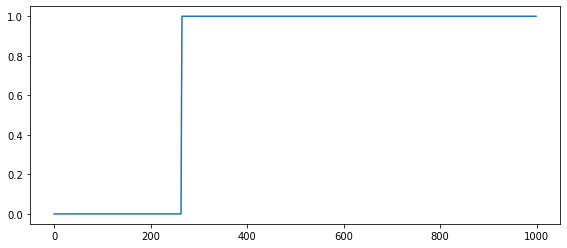

In [150]:
_,ax = plt.subplots(figsize=(9.5,4))
ax.plot(range(1000), sync[:1000]/100)

In [151]:
zfb = bb.feedback[2][np.nonzero(sync)[0][0]:]

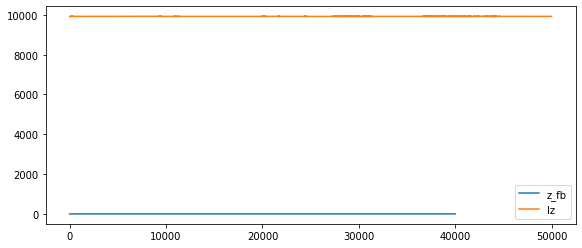

In [152]:
_,ax = plt.subplots(figsize=(9.5,4))
ax.plot(range(40000), zfb[:40000], label='z_fb')
ax.plot(range(50000), (bb.Iz+120000)/12, label='Iz')
ax.legend()